Research Objective: Prediction of Chlorophyl concentation in a pond using Machine Learning algorithms.
Data: 2014 - 2021 Water quality parameters of a pond obtained from installed sensors with 15mins frequency of readings. 
Input parameters: Turbidity, Dissolved Oxygen, Temperature, Saturated Dissolved Oxygen, pH, Specific Conductivity.
Output parameter: Chlorophyll. This parameter serves as index of algae bloom, hence the prediction of its concentration to provide an indication of water quality contamination.
Approach: Variable selection using Lasso.
Random Forest Model building with all parameters.
Random forest model building with selected variables(parameters).
ANN Model using cross validation.
Accuracy Metrics: Root Mean Square, RSquared, Correlation.
Comparing Model Accuracy results

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

Data Cleaning

In [3]:
data = pd.read_csv("Surface.csv")
data.head()
data.columns
data.isnull().sum()
data["Turbidity (FNU)"] = pd.to_numeric(data['Turbidity (FNU)'], errors = 'coerce') #Convert Turbidity to numeric data
import warnings
warnings.filterwarnings("ignore")
data['date'] = pd.to_datetime(data['TimeStamp'])
del data['TimeStamp']
profiler= data.drop(["BGA (RFU) ", "Chlorophyll (RFU)", "ORP (mV)"], axis=1)


/software/spackages/linux-centos8-x86_64/gcc-8.3.1/anaconda3-2020.07-4obfocw3kpymwz7obsjukroelfwutobz/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Missing Data Treatment

In [6]:
profiler.fillna(profiler.mean(), inplace=True)
profiler.isnull().sum()

Temperature           0
BGA (ug/l)            0
Chlorophyll (ug/l)    0
Turbidity (FNU)       0
DisOxygen Sat         0
DissOxygen (mg/l)     0
SpCond (us/cm)        0
pH                    0
date                  0
dtype: int64

Data Splitting and Standardization

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(profiler[["Turbidity (FNU)", "DissOxygen (mg/l)", "Temperature", "DisOxygen Sat ", "SpCond (us/cm)", "pH"]],
                                                    profiler["Chlorophyll (ug/l)"], train_size=0.7, random_state=123)

from sklearn.preprocessing import MinMaxScaler
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled  = scaler_y.transform(y_test)

Regularization and Variable Selection with Lasso

In [8]:
#Variable selection using LASSO
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error as mse
import numpy as np
n_lambda = 100
lambdas1 = np.logspace(-6,0, n_lambda)

MSE_train = []
MSE_test = []
coefs = []
for ld in lambdas1:
    lassocv = Lasso(alpha=ld)
    model_LS = lassocv.fit(X_train_scaled, y_train_scaled)
    y_predLS_cv_train = model_LS.predict(X_train_scaled)
    y_predLS_cv_test = model_LS.predict(X_test_scaled)
    MSE_train.append(mse(y_train_scaled,y_predLS_cv_train))
    MSE_test.append(mse(y_test_scaled,y_predLS_cv_test))
    coefs.append(model_LS.coef_)  
    
coef_df = pd.DataFrame(coefs)
coef_df.columns = X_train.columns

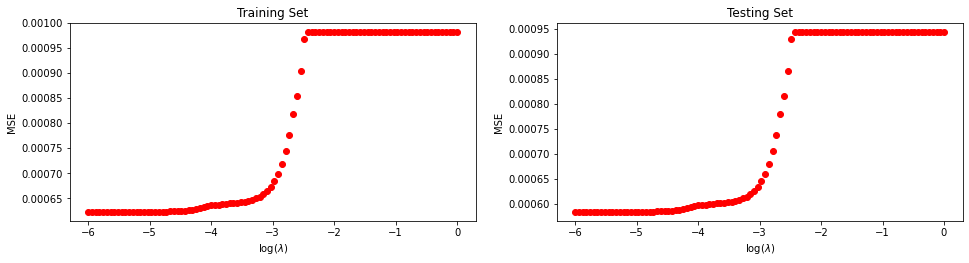

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=False)


ax1 = plt.subplot(221)
ax1.scatter(np.log10(lambdas1), MSE_train,color="red")
ax1.set_title("Training Set")
ax2 = plt.subplot(222)
ax2.scatter(np.log10(lambdas1), MSE_test,color="red")
ax2.set_title("Testing Set")

ax1.set_xlabel("log($\\lambda$)")
ax2.set_xlabel("log($\\lambda$)")
ax1.set_ylabel('MSE')
ax2.set_ylabel('MSE')

plt.show()

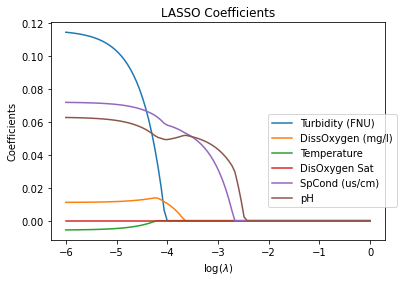

In [11]:
ax = plt.gca()
for i in range(0,coef_df.columns.size):
    ax.plot(np.log10(lambdas1), coef_df.iloc[:,i])
    
ax.legend(coef_df.columns,bbox_to_anchor = (1.05, 0.6))
#ax.set_xscale('log')
plt.xlabel("log($\\lambda$)")
plt.ylabel('Coefficients')
plt.title('LASSO Coefficients')
plt.axis('tight')
plt.show()

The selected paameters with this method will be pH and SpCond

RANDOM FOREST USING THE SIX INPUT PARAMETERS

In [14]:
#Building Model
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from scipy.stats import pearsonr
RF_model = RandomForestRegressor(n_estimators=100).fit(X_train_scaled,y_train_scaled)
y_pred_RF = RF_model.predict(X_test_scaled)

from keras.models import load_model

RF_model.save('my_RF_model.keras')

In [15]:
#MODEL EVALUATION
RMSE_RF = metrics.mean_squared_error(y_test_scaled, y_pred_RF,squared=True)
RSQUARED_RF = metrics.r2_score(y_test_scaled, y_pred_RF)
TEST = pd.DataFrame(y_test_scaled)
PRED = pd.DataFrame(y_pred_RF)
correlation_RF = pearsonr(TEST[0],PRED[0])
Metrics_RF = [RMSE_RF, RSQUARED_RF,correlation_RF]


[0.00014744361780209537, 0.8438182844876747, (0.9186587624697005, 0.0)]


ANN MODEL USING THE SIX INPUT PARAMETERS

In [22]:
# MODEL BUILDING
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(50,activation='relu',input_shape=(6,)))
model.add(Dense(40,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mae', 'mse'])

ANN_Mod2 = model.fit(X_train_scaled, y_train_scaled, epochs=100, verbose=1,
               validation_split=0.2)
from keras.models import load_model

model.save('my_ANNmodel.keras')

Epoch 1/100
2813/2813 [==============================] - 3s 935us/step - loss: 0.0023 - mae: 0.0221 - mse: 0.0023 - val_loss: 4.7303e-04 - val_mae: 0.0129 - val_mse: 4.7303e-04
Epoch 2/100
2813/2813 [==============================] - 2s 888us/step - loss: 4.2647e-04 - mae: 0.0130 - mse: 4.2647e-04 - val_loss: 4.3981e-04 - val_mae: 0.0132 - val_mse: 4.3981e-04
Epoch 3/100
2813/2813 [==============================] - 3s 889us/step - loss: 4.2172e-04 - mae: 0.0129 - mse: 4.2172e-04 - val_loss: 4.5404e-04 - val_mae: 0.0145 - val_mse: 4.5404e-04
Epoch 4/100
2813/2813 [==============================] - 2s 888us/step - loss: 4.1005e-04 - mae: 0.0127 - mse: 4.1005e-04 - val_loss: 4.1074e-04 - val_mae: 0.0123 - val_mse: 4.1074e-04
Epoch 5/100
2813/2813 [==============================] - 3s 890us/step - loss: 4.0129e-04 - mae: 0.0126 - mse: 4.0129e-04 - val_loss: 4.0336e-04 - val_mae: 0.0124 - val_mse: 4.0336e-04
Epoch 6/100
2813/2813 [==============================] - 2s 887us/step - loss: 3.95

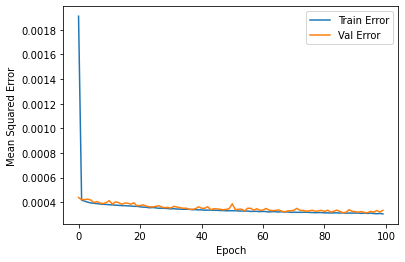

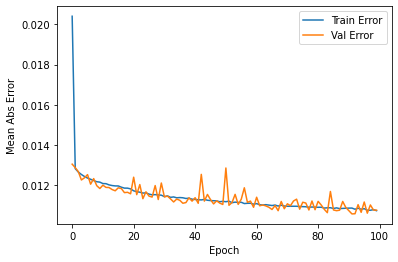

In [21]:
# Plotting Cross validation Error 
hist = pd.DataFrame(ANN_Mod2.history)
hist['epoch'] = ANN_Mod2.epoch
#hist.tail
def plot_history(ANN_Mod2):
    hist = pd.DataFrame(ANN_Mod2.history)
    hist['epoch'] = ANN_Mod2.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.plot(hist['epoch'],hist['mse'],
             label='Train Error')
    plt.plot(hist['epoch'],hist['val_mse'],
             label='Val Error')
    plt.legend()
    plt.autoscale(enable=True,axis='y',tight=None)

    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'],hist['mae'],
             label='Train Error')
    plt.plot(hist['epoch'],hist['val_mae'],
             label='Val Error')
    plt.legend()
    plt.autoscale(enable=True,axis='y',tight=None)
    
plot_history(ANN_Mod2)

In [23]:
# PREDICTIONS
predictions = model.predict(X_test_scaled)
predictions = pd.DataFrame(predictions)
y_test_scaled = pd.DataFrame(y_test_scaled)
#MODEL EVALUATION
RSQUARED_ANN = metrics.r2_score(y_test_scaled,predictions)
RMSE_ANN = metrics.mean_squared_error(y_test_scaled,predictions, squared=True)
correlation_ANN = pearsonr(y_test_scaled[0],predictions[0])
Metrics_ANN = [RMSE_ANN, RSQUARED_ANN, correlation_ANN]
print(Metrics_ANN)

[0.00028801780164249057, 0.694913113031512, (0.8347709370052313, 0.0)]


RANDOM FOREST USING THE LASSO SELECTED INPUT PARAMETERS (pH AND SpCond)

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(profiler[["SpCond (us/cm)", "pH"]],
                                                    profiler["Chlorophyll (ug/l)"], train_size=0.7, random_state=123)


In [25]:
#Standardization
from sklearn.preprocessing import MinMaxScaler
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled  = scaler_y.transform(y_test)

In [26]:
#Building Model
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from scipy.stats import pearsonr
model_RF = RandomForestRegressor(n_estimators=100).fit(X_train_scaled,y_train_scaled)
y_pred_RF = model_RF.predict(X_test_scaled)

from keras.models import load_model
model_RF_save('RF_Model2.keras')

In [27]:
#MODEL EVALUATION
RMSE_RF = metrics.mean_squared_error(y_test_scaled, y_pred_RF,squared=True)
RSQUARED_RF = metrics.r2_score(y_test_scaled, y_pred_RF)
H = pd.DataFrame(y_test_scaled)
G = pd.DataFrame(y_pred_RF)
# Predictions_RF = pd.DataFrame(Predictions_RF)
correlation_RF = pearsonr(H[0],G[0])
Metrics_RF = [RMSE_RF, RSQUARED_RF,correlation_RF]
print(Metrics_RF)

[0.00043643758380766527, 0.5376973817569559, (0.7426514103840821, 0.0)]


Comparing Model Accuracy: Based on the metric of accuracy chosen, Random Forest model seems to be the best model. It has the lowest Root mean square error value, high correlation between the prediction and observed data and a RSquared value of 84.3%, which is the highest among the chosen models. 